## <div align='center'><b> Text Analysis on News Data Using Python: Sentiment and Emotion Detection</b></div>

### **Introduction:**

> This project explores sentiment and emotion detection on BBC News articles using a combination of traditional and advanced NLP techniques. It applies lexicon-based sentiment analysis with **TextBlob, VADER, and Afinn**, alongside deep learning-based emotion detection using **Hugging Face Transformers**. Additionally, **TF-IDF & CountVectorizer** are utilized for text vectorization, and **visualization techniques** help interpret sentiment distribution.


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text2emotion as te
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor
import logging
import os
import sys

# Suppress NLTK warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*download.*")
logging.getLogger("nltk").setLevel(logging.CRITICAL)

# Redirect stdout and stderr to devnull to suppress NLTK download messages
def suppress_nltk_output():
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

def restore_output():
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__

# Suppress NLTK output and download datasets
suppress_nltk_output()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
restore_output()

# Print True to confirm that no warnings or logs will appear
print("True")

[nltk_data] Downloading package stopwords to C:\Users\Amulya
[nltk_data]     Jagadish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Amulya
[nltk_data]     Jagadish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Amulya
[nltk_data]     Jagadish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Amulya
[nltk_data]     Jagadish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Amulya
[nltk_data]     Jagadish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Amulya
[nltk_data]     Jagadish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nlt

## Data cleaning and normalization

In [2]:
df = pd.read_csv("bbc_article_mechanicalsoup.csv")

# Define a function to clean text: lowercase, remove numbers, punctuation, and extra whitespace.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the "content" column
df['clean_content'] = df['content'].astype(str).apply(clean_text)

# Remove stopwords from the cleaned text
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

df['clean_content'] = df['clean_content'].apply(remove_stopwords)

# Save the cleaned data if needed
df.to_csv("bbc_articles_cleaned.csv", index=False)
print("Data cleaning and normalization completed.")

In [3]:
df = pd.read_csv('bbc_articles_cleaned.csv')
df.head()

,title,link,content,clean_content
0,Key moments on Carney's journey from banker to...,https://www.bbc.com/news/videos/cr72021pdevo,Mark Carney has won the race to succeed Justin...,mark carney race succeed justin trudeau canada...
1,Gaza student protest leader held by US immigra...,https://www.bbc.com/news/articles/c4gdwy1gjjjo,US President Donald Trump has said a leader of...,us president donald trump said leader last yea...
2,NewsNews,https://www.bbc.com/news/wales,The 40-year-old died at the scene of the shoot...,yearold died scene shooting rhondda cynon taf ...
3,Stocks slide as Trump warns of US economy 'tra...,https://www.bbc.com/news/articles/cz61nn99eg1o,A sell-off in the US stock market gathered ste...,selloff us stock market gathered steam monday ...
4,Supreme Court will hear challenge to Colorado ...,https://www.bbc.com/news/articles/c20417r234wo,The US Supreme Court on Monday agreed to hear ...,us supreme court monday agreed hear challenge ...


## Count Vectorizer

> Purpose: Converts text data into token counts (word frequencies).


> Graph: A bar plot that shows the top 10 most frequent words in your dataset.

>Max Features: Limits the number of words to the top 10 most frequent one

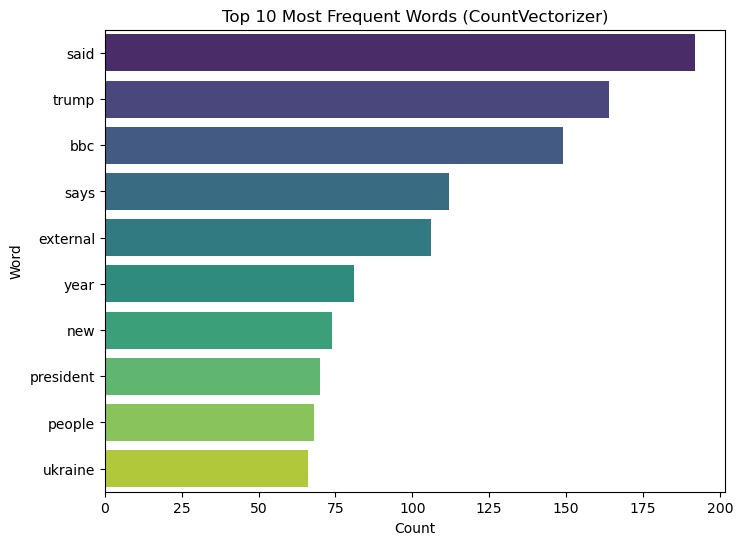

In [4]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_features=10)

# Apply CountVectorizer
count_matrix = count_vectorizer.fit_transform(df['content'])

# Get feature names (words) and their frequencies
count_words = count_vectorizer.get_feature_names_out()
count_word_freq = count_matrix.sum(axis=0).A1 

# Create DataFrame for the words and their frequencies
count_df = pd.DataFrame(zip(count_words, count_word_freq), columns=['Word', 'Count'])
count_df = count_df.sort_values(by='Count', ascending=False)

# Plot the most frequent words
plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Word', data=count_df, palette='viridis')
plt.title('Top 10 Most Frequent Words (CountVectorizer)')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

## TF-IDF Vectorizer

> Purpose: Converts text data into weighted tokens based on term frequency and inverse document frequency.

> Graph: A bar plot showing the top 10 most important words based on their TF-IDF score.

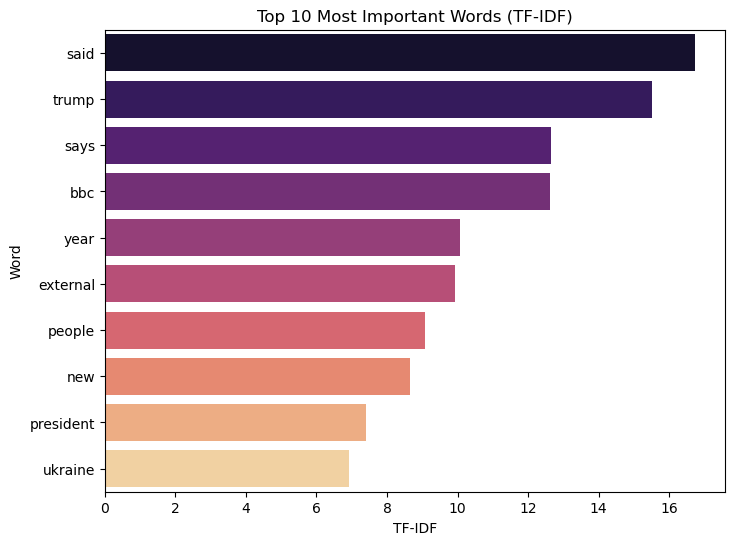

In [5]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10)

# Apply TF-IDF Vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(df['content'])

# Get feature names (words) and their TF-IDF scores
tfidf_words = tfidf_vectorizer.get_feature_names_out()
tfidf_word_freq = tfidf_matrix.sum(axis=0).A1  # A1 converts to 1D array

# Create DataFrame for the words and their TF-IDF scores
tfidf_df = pd.DataFrame(zip(tfidf_words, tfidf_word_freq), columns=['Word', 'TF-IDF'])
tfidf_df = tfidf_df.sort_values(by='TF-IDF', ascending=False)

# Plot the most important words based on TF-IDF
plt.figure(figsize=(8, 6))
sns.barplot(x='TF-IDF', y='Word', data=tfidf_df, palette='magma')
plt.title('Top 10 Most Important Words (TF-IDF)')
plt.xlabel('TF-IDF')
plt.ylabel('Word')
plt.show()

##  Sentiment Analysis using TextBlob

In [6]:
df['sentiment'] = df['content'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Categorizing sentiment as Positive, Negative, or Neutral based on polarity
df['sentiment_category'] = df['sentiment'].map(lambda polarity: 'Positive' if polarity > 0 else ('Negative' if polarity < 0 else 'Neutral'))

# Display the first 3 rows
df.head(3)

,title,link,content,clean_content,sentiment,sentiment_category
0,Key moments on Carney's journey from banker to...,https://www.bbc.com/news/videos/cr72021pdevo,Mark Carney has won the race to succeed Justin...,mark carney race succeed justin trudeau canada...,0.026235,Positive
1,Gaza student protest leader held by US immigra...,https://www.bbc.com/news/articles/c4gdwy1gjjjo,US President Donald Trump has said a leader of...,us president donald trump said leader last yea...,-0.002680,Negative
2,NewsNews,https://www.bbc.com/news/wales,The 40-year-old died at the scene of the shoot...,yearold died scene shooting rhondda cynon taf ...,0.060006,Positive


## Visualization for Sentimental Analysis

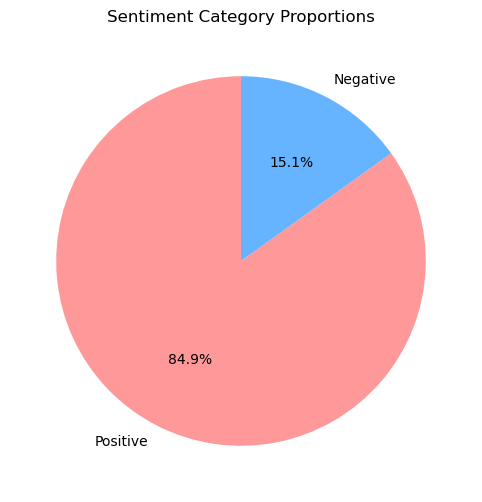

In [7]:
sentiment_category = df['sentiment_category'].value_counts()  # This will count the occurrences of each sentiment

# pie chart 
plt.figure(figsize=(8, 6))
sentiment_category.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Category Proportions')
plt.ylabel('') 
plt.show()

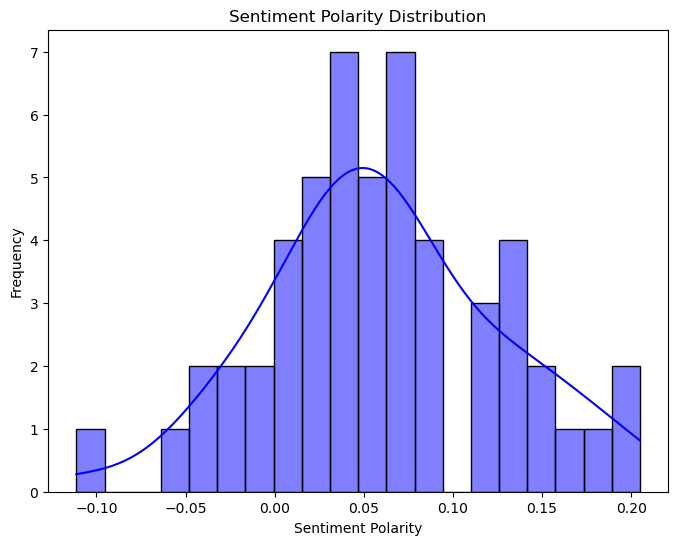

In [8]:
# histogram 
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=20, kde=True, color='blue')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

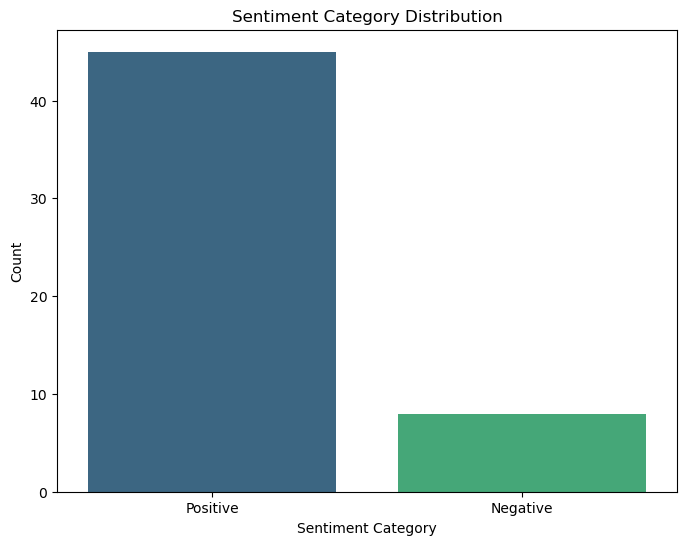

In [9]:
sentiment_counts = df['sentiment_category'].value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

##  Sentiment Analysis using VADER

In [10]:
sia = SentimentIntensityAnalyzer()

def classify_vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment classification
df['vader_category'] = df['content'].apply(classify_vader_sentiment)
df.head(2)

,title,link,content,clean_content,sentiment,sentiment_category,vader_category
0,Key moments on Carney's journey from banker to...,https://www.bbc.com/news/videos/cr72021pdevo,Mark Carney has won the race to succeed Justin...,mark carney race succeed justin trudeau canada...,0.026235,Positive,Positive
1,Gaza student protest leader held by US immigra...,https://www.bbc.com/news/articles/c4gdwy1gjjjo,US President Donald Trump has said a leader of...,us president donald trump said leader last yea...,-0.002680,Negative,Negative


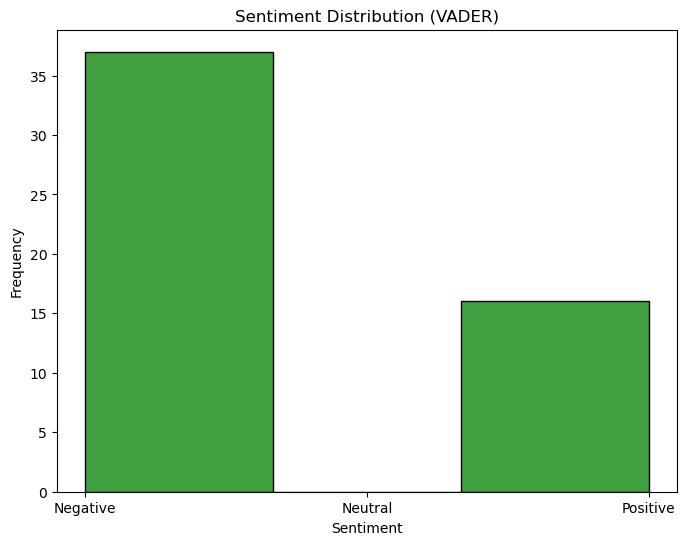

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(df['vader_category'].apply(lambda x: 1 if x == 'Positive' else (0 if x == 'Neutral' else -1)), 
             kde=False, bins=3, color='green')
plt.title('Sentiment Distribution (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(ticks=[-1, 0, 1], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

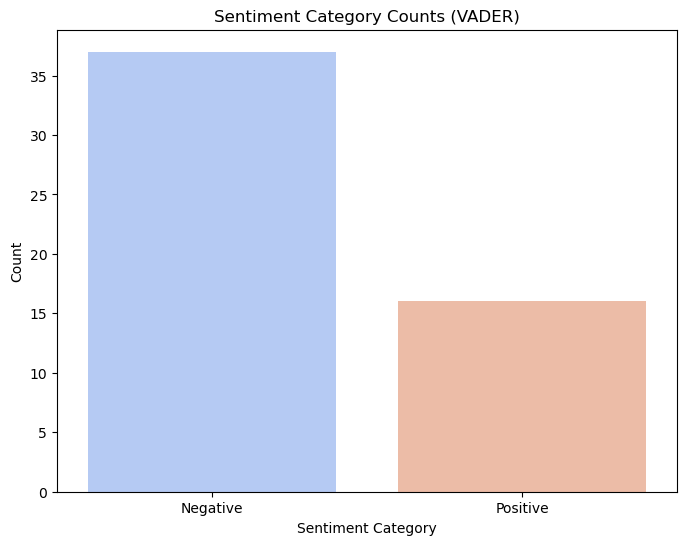

In [12]:
sentiment_counts = df['vader_category'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Sentiment Category Counts (VADER)')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

## Sentiment Analysis using Afinn

> The Afinn library returns a sentiment score for each text. Positive values indicate positive sentiment, negative values indicate negative sentiment, and zero indicates neutral sentiment.

> The scores range from -5 to +5.

In [13]:
afinn = Afinn()
df['afinn_score'] = df['content'].apply(lambda x: afinn.score(x))
df['afinn_category'] = df['afinn_score'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)
df.head(2)

,title,link,content,clean_content,sentiment,sentiment_category,vader_category,afinn_score,afinn_category
0,Key moments on Carney's journey from banker to...,https://www.bbc.com/news/videos/cr72021pdevo,Mark Carney has won the race to succeed Justin...,mark carney race succeed justin trudeau canada...,0.026235,Positive,Positive,1.0,Positive
1,Gaza student protest leader held by US immigra...,https://www.bbc.com/news/articles/c4gdwy1gjjjo,US President Donald Trump has said a leader of...,us president donald trump said leader last yea...,-0.002680,Negative,Negative,-81.0,Negative


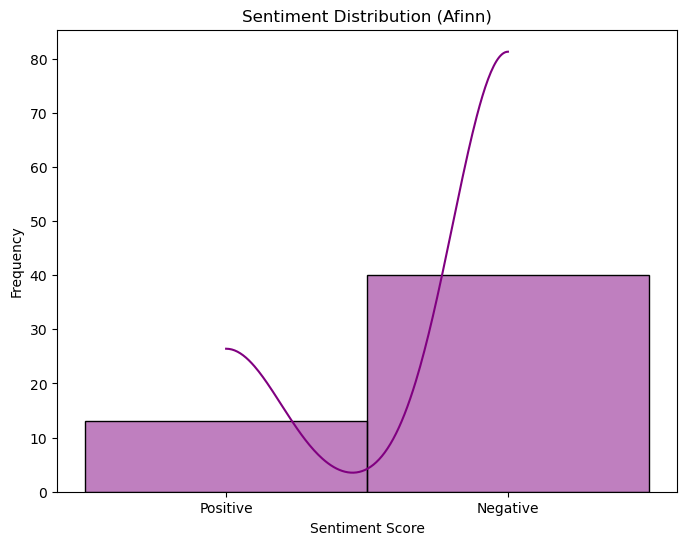

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(df['afinn_category'], bins=10, kde=True, color='purple')
plt.title('Sentiment Distribution (Afinn)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

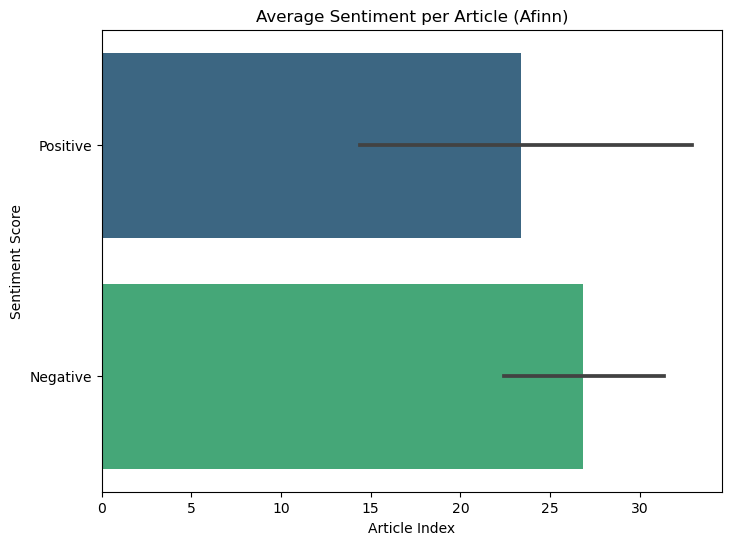

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y='afinn_category', data=df, palette='viridis')
plt.title('Average Sentiment per Article (Afinn)')
plt.xlabel('Article Index')
plt.ylabel('Sentiment Score')
plt.show()

## Comparision of 3 Algorithms for Sentimental Analysis

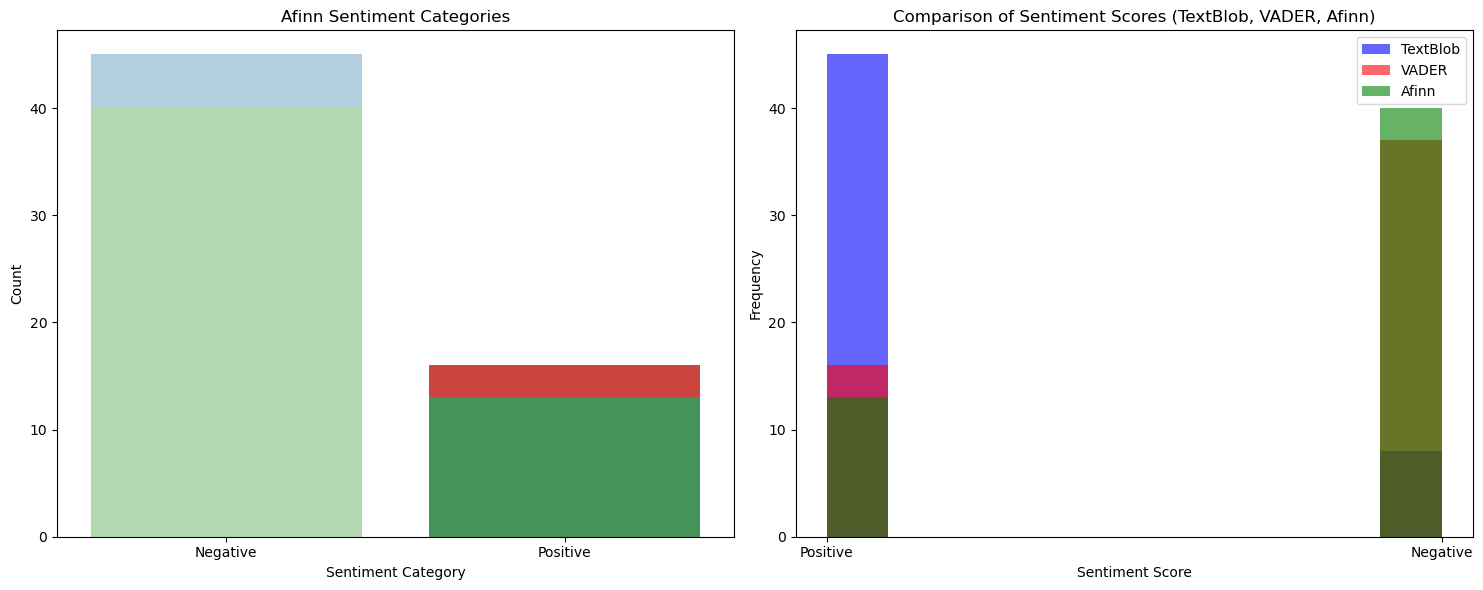

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Bar Plot for Sentiment Category Counts (for TextBlob, VADER, and Afinn)
sentiment_counts_textblob = df['sentiment_category'].value_counts()
sentiment_counts_vader = df['vader_category'].value_counts()
sentiment_counts_afinn = df['afinn_category'].value_counts()

# Plot for TextBlob
sns.barplot(x=sentiment_counts_textblob.index, y=sentiment_counts_textblob.values, ax=axes[0], palette='Blues')
axes[0].set_title('TextBlob Sentiment Categories')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Count')

# Plot for VADER
sns.barplot(x=sentiment_counts_vader.index, y=sentiment_counts_vader.values, ax=axes[0], palette='Reds')
axes[0].set_title('VADER Sentiment Categories')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Count')

# Plot for Afinn
sns.barplot(x=sentiment_counts_afinn.index, y=sentiment_counts_afinn.values, ax=axes[0], palette='Greens')
axes[0].set_title('Afinn Sentiment Categories')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Count')

# 2. Histogram for Sentiment Scores Comparison
axes[1].hist(df['sentiment_category'], bins=10, alpha=0.6, label='TextBlob', color='blue')
axes[1].hist(df['vader_category'], bins=10, alpha=0.6, label='VADER', color='red')
axes[1].hist(df['afinn_category'], bins=10, alpha=0.6, label='Afinn', color='green')

axes[1].set_title('Comparison of Sentiment Scores (TextBlob, VADER, Afinn)')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Display the plot
plt.tight_layout()
plt.show()

## Emotion Analysis with Hugging Face Transformers

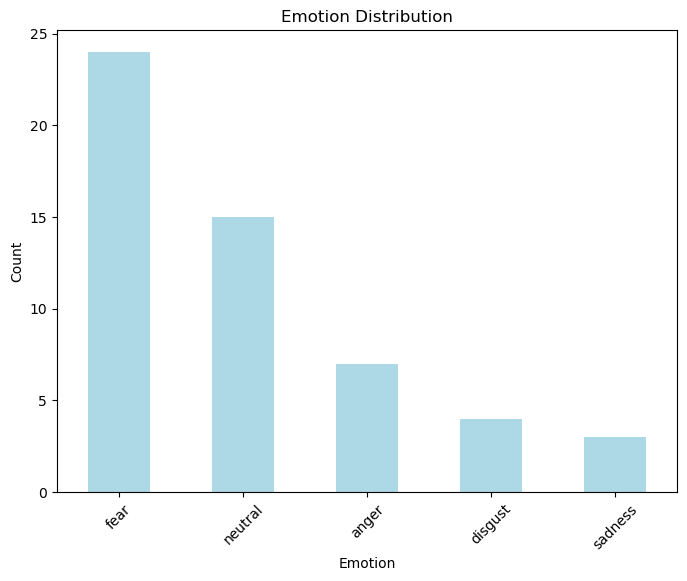

In [17]:
emotion_pipeline = pipeline("text-classification", 
                            model="j-hartmann/emotion-english-distilroberta-base", 
                            padding=True, 
                            truncation=True, 
                            max_length=512)

# Function to predict emotions
def get_emotion(text):
    result = emotion_pipeline(text)
    return result[0]['label']  # Return the predicted emotion

# Apply emotion prediction to each row in the DataFrame
df['predicted_emotion'] = df['content'].apply(get_emotion)

emotion_counts = df['predicted_emotion'].value_counts()

# Plotting the emotion distribution in a bar chart
plt.figure(figsize=(8, 6))
emotion_counts.plot(kind='bar', color='lightblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [18]:
df.head(2)

,title,link,content,clean_content,sentiment,sentiment_category,vader_category,afinn_score,afinn_category,predicted_emotion
0,Key moments on Carney's journey from banker to...,https://www.bbc.com/news/videos/cr72021pdevo,Mark Carney has won the race to succeed Justin...,mark carney race succeed justin trudeau canada...,0.026235,Positive,Positive,1.0,Positive,anger
1,Gaza student protest leader held by US immigra...,https://www.bbc.com/news/articles/c4gdwy1gjjjo,US President Donald Trump has said a leader of...,us president donald trump said leader last yea...,-0.002680,Negative,Negative,-81.0,Negative,fear


## Summary of each Article using BART

In [19]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Function to summarize each article with error handling
def summarize_article(text):
    try:
        # Ensure the text is long enough for summarization
        if len(text.split()) < 20:  # Set a threshold to avoid very short texts
            return "Text too short for summarization"

        # Summarize the text
        summary = summarizer(text, max_length=150, min_length=50, do_sample=False)
        return summary[0]['summary_text']
    
    except Exception as e:
        # Handle any errors during the summarization process
        return f"Error: {str(e)}"

# Apply the summarization function to each article in the DataFrame
df['summary'] = df['content'].apply(summarize_article)

# Display the DataFrame with original content and summaries
print(df[['content', 'summary']])

In [20]:
df.head(2)

,title,link,content,clean_content,sentiment,sentiment_category,vader_category,afinn_score,afinn_category,predicted_emotion,summary
0,Key moments on Carney's journey from banker to...,https://www.bbc.com/news/videos/cr72021pdevo,Mark Carney has won the race to succeed Justin...,mark carney race succeed justin trudeau canada...,0.026235,Positive,Positive,1.0,Positive,anger,Mark Carney has won the race to succeed Justin...
1,Gaza student protest leader held by US immigra...,https://www.bbc.com/news/articles/c4gdwy1gjjjo,US President Donald Trump has said a leader of...,us president donald trump said leader last yea...,-0.002680,Negative,Negative,-81.0,Negative,fear,Syrian-born Mahmoud Khalil was detained at his...


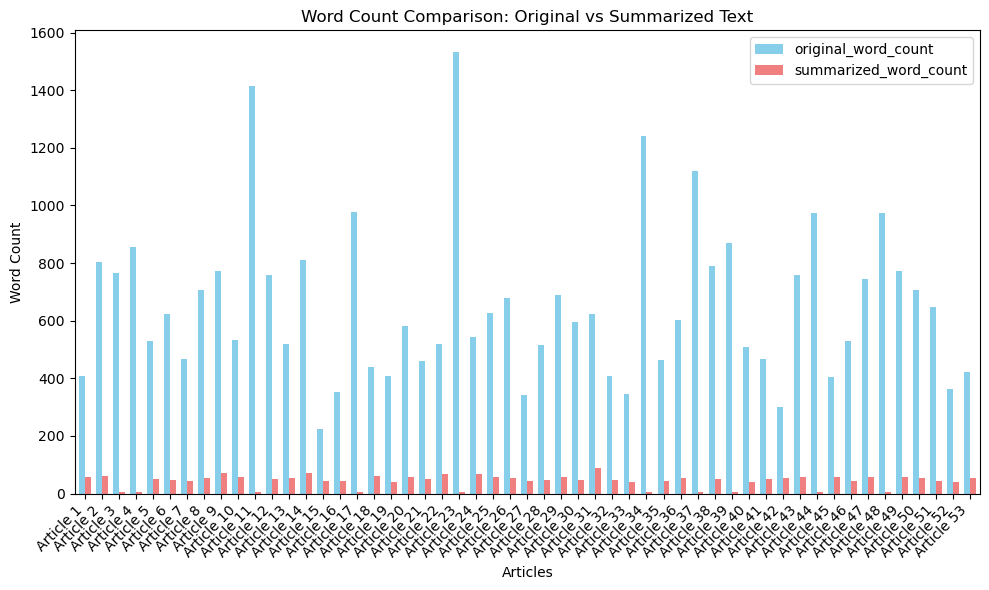

In [21]:
df1=df.copy()
df1['original_word_count'] = df1['content'].apply(lambda x: len(x.split()))
df1['summarized_word_count'] = df1['summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))

# Use a smaller bar width to avoid overcrowding the x-axis labels
df1[['original_word_count', 'summarized_word_count']].plot(kind='bar', stacked=False, color=['skyblue', 'lightcoral'], width=0.7, ax=plt.gca())

# Adding title and labels
plt.title('Word Count Comparison: Original vs Summarized Text')
plt.xlabel('Articles')
plt.ylabel('Word Count')

# Make x-ticks readable by rotating and setting limits
plt.xticks(range(len(df1)), [f'Article {i+1}' for i in range(len(df1))], rotation=45, ha='right')
plt.tight_layout()
plt.show()

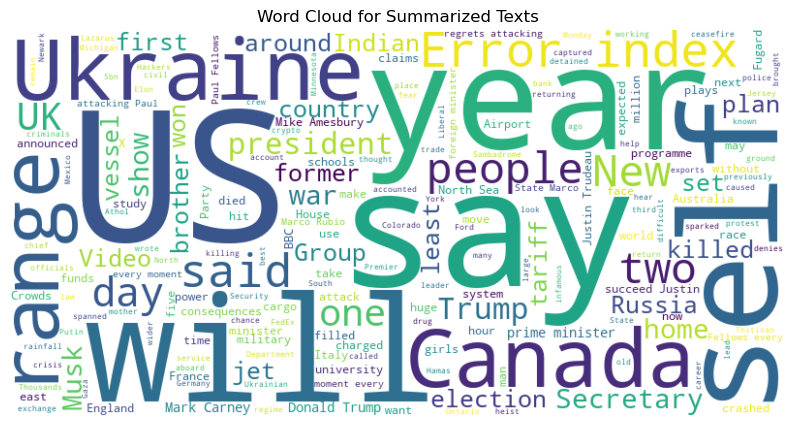

In [22]:
# Combine all summaries into one large text string
all_summaries = " ".join(df1['summary'])

# Create a word cloud from the summarized text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_summaries)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Summarized Texts')
plt.show()

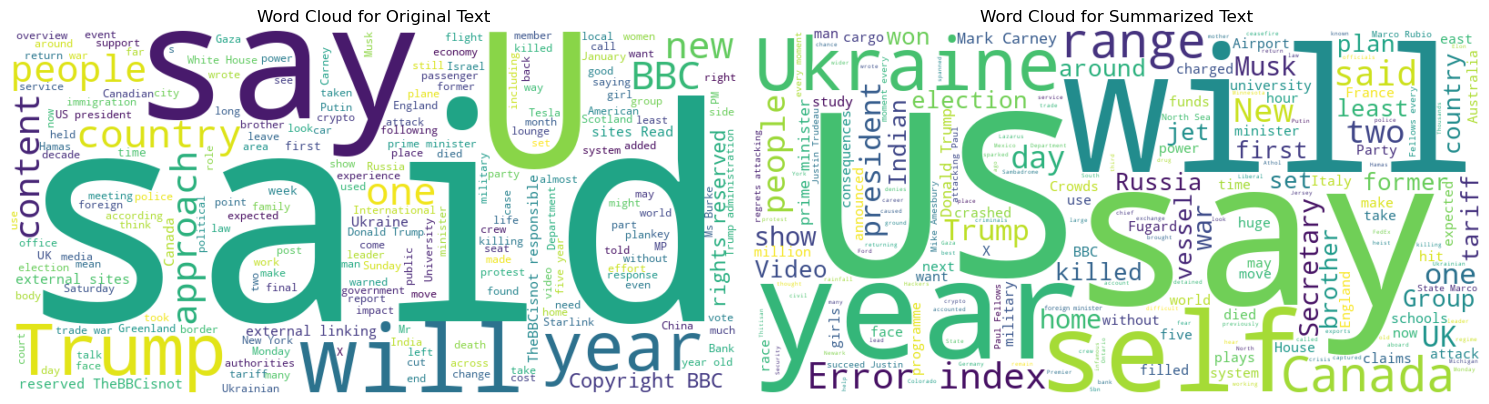

In [23]:
# Combine all original and summarized texts into one large string
original_text = " ".join(df['content'])
summarized_text = " ".join(df['summary'])

# Create a word cloud for the original text
wordcloud_original = WordCloud(width=800, height=400, background_color='white').generate(original_text)

# Create a word cloud for the summarized text
wordcloud_summarized = WordCloud(width=800, height=400, background_color='white').generate(summarized_text)

# Plot the word clouds
plt.figure(figsize=(15, 8))

# Plot original text word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Original Text')

# Plot summarized text word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summarized, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Summarized Text')

plt.tight_layout()
plt.show()

In [24]:
df.to_csv('Final_articles.csv', index=False)

## Conclusion:

- **TextBlob** for polarity-based sentiment classification.  
- **VADER** for rule-based sentiment analysis, particularly effective for informal text.  
- **Afinn** for lexicon-based sentiment scoring, providing numerical sentiment values.  
- **Hugging Face Transformers** for deep learning-based emotion detection, leveraging advanced contextual understanding.  
- **TF-IDF & CountVectorizer** for converting textual data into structured numerical representations.  
- **Visualization techniques** such as word clouds and distribution plots to enhance interpretability.  


### **Comparison Table:**

| **Algorithm**               | **Strengths**                                          | **Limitations**                                    |
|----------------------------|------------------------------------------------------|--------------------------------------------------|
| **TextBlob**               | Simple, quick polarity detection                    | Limited contextual accuracy                      |
| **VADER**                  | Great for short texts, emoji-aware                  | Less effective on long formal text              |
| **Afinn**                  | Fast, lexicon-based sentiment scoring               | No contextual understanding                     |
| **Hugging Face Transformers** | Context-aware deep learning-based emotion detection | Computationally expensive, requires large datasets |
| **TF-IDF & CountVectorizer** | Efficient text vectorization for NLP models        | Requires additional processing for sentiment analysis |
